# Counting multiple detectors
How does having a second detector on the same thing help identify the underlying distribution

In [20]:
%matplotlib inline

from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as mc
import spacepy.toolbox as tb
import spacepy.plot as spp
import tqdm
from scipy import stats


%matplotlib inline

## Generate some data

In [21]:
np.random.seed(8675309)
d1 = np.random.poisson(10, size=10000)
d2 = np.random.poisson(10, size=10000)


## Use just one and see (10 points)

In [22]:
with mc.Model() as model0:
    mu0 = mc.Uniform('mu', 0, 1000)
    det1 = mc.Poisson('d1', mu=mu0, observed=d1[0:10])
    #     det2 = mc.Poisson('d2', mu=mu, observed=d2[0:10])
    start = mc.find_MAP()
    trace0 = mc.sample(10000, start=start)

Optimization terminated successfully.
         Current function value: 28.463527
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 375.21:   5%|▍         | 9893/200000 [00:03<01:06, 2858.20it/s] 
Convergence archived at 9900
Interrupted at 9,900 [4%]: Average Loss = 1,903.1
100%|██████████| 10500/10500 [00:05<00:00, 2099.59it/s]


In [23]:
mc.summary(trace0)


mu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  8.907            0.945            0.015            [7.184, 10.893]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  7.147          8.250          8.890          9.504          10.868



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e5810b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12e7e5da0>]], dtype=object)

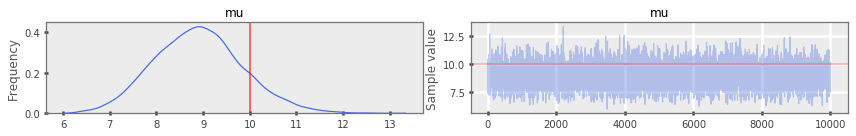

In [24]:
mc.traceplot(trace0, lines={'mu':10})

## Use both independently (10 points)

In [25]:
with mc.Model() as model1:
    mu = mc.Uniform('mu', 0, 1000)
    det1 = mc.Poisson('d1', mu=mu, observed=d1[0:10])
    det2 = mc.Poisson('d2', mu=mu, observed=d2[0:10])
    start = mc.find_MAP()
    trace = mc.sample(10000, start=start)

Optimization terminated successfully.
         Current function value: 58.877246
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 736.84:   5%|▍         | 9847/200000 [00:03<01:06, 2845.88it/s] 
Convergence archived at 9900
Interrupted at 9,900 [4%]: Average Loss = 3,782.5
100%|██████████| 10500/10500 [00:05<00:00, 2009.26it/s]


In [26]:
mc.summary(trace)


mu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  9.355            0.680            0.012            [8.004, 10.644]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  8.059          8.893          9.344          9.801          10.727



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e5f0d30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x132267dd8>]], dtype=object)

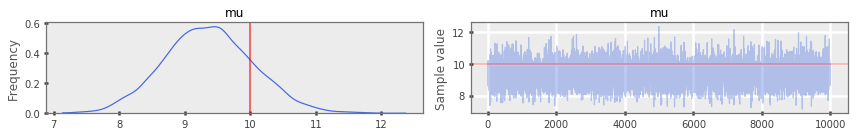

In [27]:
mc.traceplot(trace, lines={'mu':10})

## Use the answer from one as the prior for the second

In [28]:
with mc.Model() as model1:
    mu = mc.Uniform('mu', 0, 1000)
    det1 = mc.Poisson('d1', mu=mu, observed=d1[0:10])
    #     det2 = mc.Poisson('d2', mu=mu, observed=d2[0:100])
    start = mc.find_MAP()
    trace = mc.sample(10000, start=start)
    
    
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)
    
    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return mc.Interpolated(param, x, y)
    
    
with mc.Model() as model2:
    mu2 = from_posterior('mu', trace['mu'])
    det2 = mc.Poisson('d2', mu=mu2, observed=d2[0:10])
    start = mc.find_MAP()
    trace2 = mc.sample(10000, start=start)

Optimization terminated successfully.
         Current function value: 28.463527
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 375.21:   5%|▍         | 9842/200000 [00:03<01:07, 2834.23it/s] 
Convergence archived at 9900
Interrupted at 9,900 [4%]: Average Loss = 1,903.1
100%|██████████| 10500/10500 [00:05<00:00, 2079.98it/s]


Optimization terminated successfully.
         Current function value: 28.712038
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 31.167:   7%|▋         | 14181/200000 [00:05<01:15, 2453.09it/s]
Convergence archived at 14200
Interrupted at 14,200 [7%]: Average Loss = 41.004
100%|██████████| 10500/10500 [00:07<00:00, 1352.54it/s]


In [29]:
mc.summary(trace2)


mu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  9.355            0.678            0.012            [7.974, 10.673]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  8.056          8.893          9.344          9.803          10.776



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1337a1fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1337d2780>]], dtype=object)

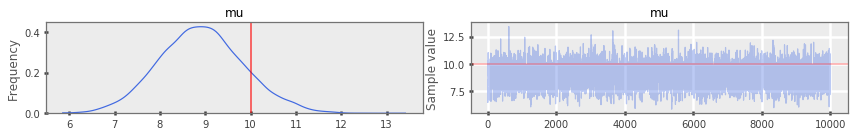

In [30]:
mc.traceplot(trace, lines={'mu':10})